In [1]:
%pwd

'/home/deepak/learning_project/student'

In [2]:
%cd /home/deepak/learning_project/student

/home/deepak/learning_project/student


In [3]:
! pip install tensorboardX

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import torch
from torch import nn, optim, autograd
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.nn import functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tensorboardX import SummaryWriter
from tqdm import tqdm
import os
import os.path
import errno

In [5]:
torch.cuda.is_available()

/home/deepak/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


False

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cpu


In [7]:
np.random.seed(42)
torch.manual_seed(42)

In [8]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)

Dataset

In [9]:
class DataNShot():
    def __init__(self, root, data_npy, train_subj, test_subj, batchsz, n_way, k_shot, k_query, eeg_shape, num_trials, batchst=1):
        self.num_trials = num_trials
        self.batchsz = {"train": batchsz, "test": batchst}
        self.n_way = n_way
        self.k_shot = k_shot
        self.k_query = k_query
        self.eeg_shape = eeg_shape
        self.root = root
        self.data_npy = data_npy
        self.train_subj = train_subj
        self.test_subj = test_subj
        self.subj = {"train": self.train_subj, "test": self.test_subj}

    def get_data(self, mode, subj, cls, trial):
        return np.load(os.path.join(self.root, self.data_npy+'_'+'train', f"s{subj}_c{cls}_t{trial}.npy"))
        # return raw - raw.mean(axis=0)

    def get_batch(self, mode):
        setsz = self.k_shot * self.n_way
        querysz = self.k_query * self.n_way
        num_subj = self.subj[mode]

        support_x = np.zeros((self.batchsz[mode], setsz) + self.eeg_shape)
        support_y = np.zeros((self.batchsz[mode], setsz), dtype=int)
        query_x = np.zeros((self.batchsz[mode], querysz) + self.eeg_shape)
        query_y = np.zeros((self.batchsz[mode], querysz), dtype=int)

        selected_tasks = np.random.choice(num_subj, self.batchsz[mode], False)
        for i, cur_task in enumerate(selected_tasks):
            shuffle_idx = np.arange(self.n_way)
            np.random.shuffle(shuffle_idx)
            shuffle_idx_test = np.arange(self.n_way)
            np.random.shuffle(shuffle_idx_test)

            for j in range(self.n_way):
                selected_data = np.random.choice(self.num_trials, self.k_shot + self.k_query, False)

                for offset, eeg in enumerate(selected_data[:self.k_shot]):
                    support_x[i, shuffle_idx[j] * self.k_shot + offset, ...] = self.get_data(mode, cur_task, j, eeg)
                    support_y[i, shuffle_idx[j] * self.k_shot + offset] = j

                for offset, eeg in enumerate(selected_data[self.k_shot:]):
                    query_x[i, shuffle_idx_test[j] * self.k_query + offset, ...] = self.get_data(mode, cur_task, j, eeg)
                    query_y[i, shuffle_idx_test[j] * self.k_query + offset] = j

        return support_x, support_y, query_x, query_y

In [10]:
class CustomDataset(Dataset):
    def __init__(self, db, mode, k_shot, k_query) -> None:
        super().__init__()
        # self.data = data
        self.db = db
        self.mode = mode
        self.shape = (len(db.subj[mode]), db.n_way, db.num_trials) + db.eeg_shape
        self.n_way = self.shape[1]
        self.k_shot = k_shot
        self.k_query = k_query
        self.out_shape = (self.n_way * self.k_shot,) + self.shape[-2:]
        self.out_shape_query = (self.n_way * self.k_query,) + self.shape[-2:]
        self.shuffle_idx = np.zeros(self.shape[:3], dtype=int)
        for p in range(self.shape[0]):
            for q in range(self.shape[1]):
                idx_range = np.arange(self.shape[2])
                np.random.shuffle(idx_range)
                self.shuffle_idx[p, q, ...] = idx_range

    def __len__(self):
        return self.shape[0] * (self.shape[2] // (self.k_shot + self.k_query))

    def __getitem__(self, idx):
        idx2 = (self.k_shot + self.k_query) * (idx // self.shape[0])
        idx0 = idx % self.shape[0]

        support_x = np.zeros(self.out_shape)
        support_y = np.zeros(self.out_shape[:1], dtype=int)
        query_x = np.zeros(self.out_shape_query)
        query_y = np.zeros(self.out_shape_query[:1], dtype=int)

        for j in range(self.n_way):
            # support_x[(j*self.k_shot):((j+1)*self.k_shot), ...] = self.data[idx0][j][self.shuffle_idx[idx0, j, idx2:idx2+self.k_shot]]
            for v in range(self.k_shot):
                support_x[(j*self.k_shot) + v, ...] = self.db.get_data(self.mode, self.db.subj[self.mode][idx0], j, self.shuffle_idx[idx0, j, idx2+v])
            support_y[(j*self.k_shot):((j+1)*self.k_shot)] = j

            # query_x[(j*self.k_query):((j+1)*self.k_query), ...] = self.data[idx0][j][self.shuffle_idx[idx0, j, idx2+self.k_shot:idx2+self.k_shot+self.k_query]]
            for v in range(self.k_query):
                query_x[(j*self.k_query) + v, ...] = self.db.get_data(self.mode, self.db.subj[self.mode][idx0], j, self.shuffle_idx[idx0, j, idx2+self.k_shot+v])
            query_y[(j*self.k_query):((j+1)*self.k_query)] = j

        return support_x, support_y, query_x, query_y

In [11]:
class ZeroDataset(Dataset):
    def __init__(self, db, mode, k_shot, k_query, subj) -> None:
        super().__init__()
        # self.data = data
        self.db = db
        self.mode = mode
        self.subj = subj
        self.shape = (1, db.n_way, db.num_trials) + db.eeg_shape
        self.n_way = self.shape[1]
        self.k_shot = k_shot
        self.k_query = k_query
        self.out_shape = (self.n_way * self.k_shot,) + self.shape[-2:]
        self.out_shape_query = (self.n_way * self.k_query,) + self.shape[-2:]
        self.shuffle_idx = np.zeros(self.shape[:3], dtype=int)
        for p in range(self.shape[0]):
            for q in range(self.shape[1]):
                idx_range = np.arange(self.shape[2])
                np.random.shuffle(idx_range)
                self.shuffle_idx[p, q, ...] = idx_range

    def __len__(self):
        return self.shape[0] * (self.shape[2] // (self.k_shot + self.k_query))

    def __getitem__(self, idx):
        idx2 = (self.k_shot + self.k_query) * (idx // self.shape[0])
        idx0 = idx % self.shape[0]

        support_x = np.zeros(self.out_shape)
        support_y = np.zeros(self.out_shape[:1], dtype=int)
        query_x = np.zeros(self.out_shape_query)
        query_y = np.zeros(self.out_shape_query[:1], dtype=int)

        for j in range(self.n_way):
            # support_x[(j*self.k_shot):((j+1)*self.k_shot), ...] = self.data[idx0][j][self.shuffle_idx[idx0, j, idx2:idx2+self.k_shot]]
            for v in range(self.k_shot):
                support_x[(j*self.k_shot) + v, ...] = self.db.get_data(self.mode, self.subj, j, self.shuffle_idx[idx0, j, idx2+v])
            support_y[(j*self.k_shot):((j+1)*self.k_shot)] = j

            # query_x[(j*self.k_query):((j+1)*self.k_query), ...] = self.data[idx0][j][self.shuffle_idx[idx0, j, idx2+self.k_shot:idx2+self.k_shot+self.k_query]]
            for v in range(self.k_query):
                query_x[(j*self.k_query) + v, ...] = self.db.get_data(self.mode, self.subj, j, self.shuffle_idx[idx0, j, idx2+self.k_shot+v])
            query_y[(j*self.k_query):((j+1)*self.k_query)] = j

        return support_x, support_y, query_x, query_y

Reptile

In [12]:
class Learner(nn.Module):
    '''
    It stores a specific nn.Module class
    '''

    def __init__(self, net_class, *args) -> None:
        '''
        net_class is a class, not an instance
        args: the parameters for net_class
        '''
        super(Learner, self).__init__()
        assert net_class.__class__ == type

        self.net = net_class(*args).to(DEVICE)
        self.net_pi = net_class(*args).to(DEVICE)
        self.learner_lr = 0.1
        self.optimizer = optim.SGD(self.net_pi.parameters(), self.learner_lr)

    def parameters(self):
        '''
        ignore self.net_pi.parameters()
        '''
        return self.net.parameters()

    def update_pi(self):
        for m_from, m_to in zip(self.net.modules(), self.net_pi.modules()):
            if isinstance(m_to, nn.Linear) or isinstance(m_to, nn.Conv2d) or isinstance(m_to, nn.BatchNorm2d):
                m_to.weight.data = m_from.weight.data.clone()
                if m_to.bias is not None:
                    m_to.bias.data = m_from.bias.data.clone()

    def forward(self, support_x, support_y, query_x, query_y, num_updates, testing=False):
        self.update_pi()
        if testing:
            self.net_pi.freeze()
        for i in range(num_updates):
            loss, pred = self.net_pi(support_x, support_y)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        if testing:
            self.net_pi.unfreeze()
        loss, pred = self.net_pi(query_x, query_y)
        indices = torch.argmax(pred, dim=1)
        correct = torch.eq(indices, query_y).sum().item()
        acc = correct / query_y.size(0)

        grads_pi = autograd.grad(loss, self.net_pi.parameters(), create_graph=True)
        return loss, grads_pi, acc

    def net_forward(self, support_x, support_y):
        loss, pred = self.net(support_x, support_y)
        return loss, pred

In [13]:
class MetaLearner(nn.Module):
    def __init__(self, net_class, net_class_args, n_way, k_shot, meta_batchesz, beta, num_updates, num_updates_test) -> None:
        super(MetaLearner, self).__init__()
        self.n_way = n_way
        self.k_shot = k_shot
        self.meta_batchesz = meta_batchesz
        self.beta = beta
        self.num_updates = num_updates
        self.num_updates_test = num_updates_test

        self.learner = Learner(net_class, *net_class_args)
        self.optimizer = optim.Adam(self.learner.parameters(), lr=beta)

    def write_grads(self, dummy_loss, sum_grads_pi):
        hooks = []
        for i, v in enumerate(self.learner.parameters()):
            def closure():
                ii = i
                return lambda grad : sum_grads_pi[ii]
            # h = v.register_hook(closure())
            hooks.append(v.register_hook(closure()))

        self.optimizer.zero_grad()
        dummy_loss.backward()
        self.optimizer.step()

        for h in hooks:
            h.remove()

    def forward(self, support_x, support_y, query_x, query_y):
        sum_grads_pi = None
        meta_batchesz = support_y.size(0)

        accs = []
        for i in range(meta_batchesz):
            _, grad_pi, episode_acc = self.learner(support_x[i], support_y[i], query_x[i], query_y[i], self.num_updates)
            accs.append(episode_acc)
            if sum_grads_pi is None:
                sum_grads_pi = grad_pi
            else:
                sum_grads_pi = [torch.add(p, q) for p, q in zip(sum_grads_pi, grad_pi)]
        dummy_loss, _ = self.learner.net_forward(support_x[0], support_y[0])
        self.write_grads(dummy_loss, sum_grads_pi)

        return accs

    def pred(self, support_x, support_y, query_x, query_y):
        meta_batchesz = support_y.size(0)
        accs = []
        for i in range(meta_batchesz):
            _, _, episode_acc = self.learner(support_x[i], support_y[i], query_x[i], query_y[i], self.num_updates_test, testing=True)
            accs.append(episode_acc)
        return np.array(accs).mean()

Models

In [14]:
class EEGNet(nn.Module):
    def __init__(self, nb_classes, Chans = 22, Samples = 1001,
                 dropoutRate = 0.5, kernLength = 64, F1 = 8,
                 D = 2, F2 = 16, norm_rate = 0.25) -> None:
        super().__init__()
        self.device = DEVICE

        self.block1 = nn.Sequential(
            nn.Conv2d(1, F1, (1, kernLength), padding='same', bias=False),
            nn.BatchNorm2d(F1),
            nn.Conv2d(F1, F1 * D, (Chans, 1), groups=F1, bias=False),
            nn.BatchNorm2d(F1 * D),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(dropoutRate)
        ).to(DEVICE)

        self.block2 = nn.Sequential(
            nn.Conv2d(F2, F2, (1, 16), padding='same', bias=False),
            nn.Conv2d(F2, F2, 1, padding=0, bias=False),
            nn.BatchNorm2d(F2),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(dropoutRate)
        ).to(DEVICE)

        self.block_weights = ['block1.0.weight', 'block1.1.weight', 'block1.1.bias', 'block1.2.weight', 'block1.3.weight', 'block1.3.bias', 'block2.0.weight', 'block2.1.weight', 'block2.2.weight', 'block2.2.bias']

        self.classifier_input = 16 * ((Samples // 4) // 8)
        self.classifier_hidden = int((self.classifier_input * nb_classes) ** 0.5)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.classifier_input, self.classifier_hidden),
            nn.Linear(self.classifier_hidden, nb_classes)
        ).to(DEVICE)

        self.criterion = nn.CrossEntropyLoss(reduction='mean')

    def forward(self, x, target=None):
        x = self.block1(torch.unsqueeze(x, 1))
        x = self.block2(x)
        pred = self.classifier(x)

        loss = self.criterion(pred, target)
        return loss, pred

    def freeze(self):
        for name, param in self.named_parameters():
            if name in self.block_weights:
                param.requires_grad = False

    def unfreeze(self):
        for name, param in self.named_parameters():
            if name in self.block_weights:
                param.requires_grad = True

Train

In [15]:
def meta_train(db, meta, iterations):
    tb = SummaryWriter('runs')
    for episode_num in range(iterations):
        support_x, support_y, query_x, query_y = db.get_batch('train')
        support_x = Variable( torch.from_numpy(support_x).float()).to(DEVICE)
        query_x = Variable( torch.from_numpy(query_x).float()).to(DEVICE)
        support_y = Variable(torch.from_numpy(support_y).long()).to(DEVICE)
        query_y = Variable(torch.from_numpy(query_y).long()).to(DEVICE)

        accs = meta(support_x, support_y, query_x, query_y)
        train_acc = 100 * np.array(accs).mean()

        if episode_num % 50 == 0:
            test_accs = []
            for i in range(min(episode_num // 5000 + 3, 10)):
                support_x, support_y, query_x, query_y = db.get_batch('test')
                support_x = Variable( torch.from_numpy(support_x).float()).to(DEVICE)
                query_x = Variable( torch.from_numpy(query_x).float()).to(DEVICE)
                support_y = Variable(torch.from_numpy(support_y).long()).to(DEVICE)
                query_y = Variable(torch.from_numpy(query_y).long()).to(DEVICE)

                test_acc = meta.pred(support_x, support_y, query_x, query_y)
                test_accs.append(test_acc)

            test_acc = 100 * np.array(test_accs).mean()
            print('episode:', episode_num, '\tfinetune acc:%.6f' % train_acc, '\t\ttest acc:%.6f' % test_acc)
            tb.add_scalar('test-acc', test_acc)
            tb.add_scalar('finetune-acc', train_acc)

In [16]:
def train(net, train_loader, epochs):
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    train_log = []
    val_log = []
    for epoch in range(epochs):
        accs = []
        train_loss = []
        val_loss = []
        for support_x, support_y, query_x, query_y in tqdm(train_loader):
            support_x = Variable(support_x[0].float()).to(DEVICE)
            query_x = Variable(query_x[0].float()).to(DEVICE)
            support_y = Variable(support_y[0].long()).to(DEVICE)
            query_y = Variable(query_y[0].long()).to(DEVICE)

            net.train()
            loss, pred = net(support_x, support_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

            net.eval()
            loss, pred = net(query_x, query_y)
            val_loss.append(loss.item())
            indices = torch.argmax(pred, dim=1)
            correct = torch.eq(indices, query_y).sum().item()
            acc = correct / query_y.size(0)
            accs.append(acc)
        train_loss = np.array(train_loss).mean()
        train_log.append(train_loss)
        val_loss = np.array(val_loss).mean()
        val_log.append(val_loss)
        accuracy = 100 * np.array(accs).mean()
        print(f'Epoch {epoch+1}:', '\tvalidation acc: %.6f' % accuracy, '\tvalidation loss: %.6f' % val_loss, '\ttrain loss: %.6f' % train_loss)
    plt.plot(train_log)
    plt.plot(val_log)
    plt.show()

Evaluate

In [17]:
def evaluate(learner, db, min_updates_test=5, max_updates_test=150):
    test_loader = DataLoader(
        dataset = CustomDataset(db, "test", k_shot=0, k_query=4),
        batch_size = 1
    )
    accs = []
    for support_x, support_y, query_x, query_y in test_loader:
        support_x = Variable(support_x[0].float()).to(DEVICE)
        query_x = Variable(query_x[0].float()).to(DEVICE)
        support_y = Variable(support_y[0].long()).to(DEVICE)
        query_y = Variable(query_y[0].long()).to(DEVICE)
        _, _, episode_acc = learner(support_x, support_y, query_x, query_y, 0, testing=True)
        accs.append(episode_acc)
    accs = 100 * np.array(accs)

    results = [{"mean":accs.mean(), "std":accs.std(), "num_upd":0}]
    print(f"{0}-shot accuracy: \tmean: {results[0]['mean']:.6f}{'%'}\tstd: {results[0]['std']:.6f}{'%'}")

    for K in range(1, 11):
        dct = {"mean":0, "std":0, "num_upd":0}
        for num_updates_test in tqdm(range(min_updates_test, max_updates_test, 2)):
            test_loader = DataLoader(
                dataset = CustomDataset(db, "test", k_shot=K, k_query=4),
                batch_size = 1
            )
            accs = []
            for support_x, support_y, query_x, query_y in test_loader:
                support_x = Variable(support_x[0].float()).to(DEVICE)
                query_x = Variable(query_x[0].float()).to(DEVICE)
                support_y = Variable(support_y[0].long()).to(DEVICE)
                query_y = Variable(query_y[0].long()).to(DEVICE)
                _, _, episode_acc = learner(support_x, support_y, query_x, query_y, num_updates_test, testing=True)
                accs.append(episode_acc)
            accs = 100 * np.array(accs)
            if accs.mean() > dct["mean"]:
                dct["mean"] = accs.mean()
                dct["std"] = accs.std()
                dct["num_upd"] = num_updates_test

        results.append(dct)
        print(f"{K}-shot accuracy: \tmean: {dct['mean']:.6f}{'%'}\tstd: {dct['std']:.6f}{'%'}\tafter {dct['num_upd']} updates")

    return results

In [18]:
def evaluate0(learner, db):
    for subj in db.subj['train']:
        test_loader = DataLoader(
            dataset = ZeroDataset(db, "train", k_shot=0, k_query=4, subj=subj),
            batch_size = 1
        )
        accs = []
        for support_x, support_y, query_x, query_y in test_loader:
            support_x = Variable(support_x[0].float()).to(DEVICE)
            query_x = Variable(query_x[0].float()).to(DEVICE)
            support_y = Variable(support_y[0].long()).to(DEVICE)
            query_y = Variable(query_y[0].long()).to(DEVICE)
            _, _, episode_acc = learner(support_x, support_y, query_x, query_y, 0, testing=True)
            accs.append(episode_acc)
        accs = 100 * np.array(accs)

        results = [{"mean":accs.mean(), "std":accs.std(), "num_upd":0}]
        print(f"{0}-shot accuracy on subject {subj}: \tmean: {results[0]['mean']:.6f}{'%'}\tstd: {results[0]['std']:.6f}{'%'}")

Helper functions

In [19]:
def bciiv2a(model, iterations=30000, epochs=100, Reptile=True):
    root = ''
    data_npy = 'bciiv2a'
    # dataset = BNCI2014001()
    meta_batchsz = 5
    n_way = 4
    k_shot = 4
    k_query = k_shot

    meta_lr = 1e-3
    num_updates = 2
    num_updates_test = 10

    # fmin, fmax = 4, 32
    # raw = dataset.get_data(subjects=[1])[1]['session_T']['run_1']
    # dataset_channels = raw.pick_types(eeg=True).ch_names
    # sfreq = 250.
    # prgm_MI_classes = MotorImagery(n_classes=4, channels=dataset_channels, resample=sfreq, fmin=fmin, fmax=fmax)
    
    i = 1
    train_subj = list(range(1, i)) + list(range(i+1, 10))
    test_subj = [i]

    db = DataNShot(root, data_npy, train_subj, test_subj, meta_batchsz, n_way, k_shot, k_query, (22, 1001), 144)

    if Reptile:
        meta = MetaLearner(model, (4, 22, 1001), n_way=n_way, k_shot=k_shot, meta_batchesz=meta_batchsz, beta=meta_lr, num_updates=num_updates, num_updates_test=num_updates_test).to(DEVICE)
        meta_train(db, meta, iterations)
        return meta.learner, db
    else:
        net = model(4, 22, 1001).to(DEVICE)

        g = torch.Generator()
        g.manual_seed(42)
        train_loader = DataLoader(
            dataset = CustomDataset(db, "train", k_shot=k_shot, k_query=1),
            batch_size = 1,
            shuffle = True,
            worker_init_fn=seed_worker,
            generator=g
        )
        train(net, train_loader, epochs)
        net_trained = Learner(model, 4, 22, 1001)
        net_trained.net = net
        return net_trained, db

Results

  0%|          | 0/224 [00:00<?, ?it/s]/home/deepak/.local/lib/python3.8/site-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 224/224 [00:06<00:00, 34.48it/s]


Epoch 1: 	validation acc: 31.361607 	validation loss: 1.445162 	train loss: 1.324121


100%|██████████| 224/224 [00:06<00:00, 32.71it/s]


Epoch 2: 	validation acc: 36.718750 	validation loss: 1.510015 	train loss: 1.243734


100%|██████████| 224/224 [00:06<00:00, 35.18it/s]


Epoch 3: 	validation acc: 39.620536 	validation loss: 1.473118 	train loss: 1.195815


100%|██████████| 224/224 [00:06<00:00, 34.61it/s]


Epoch 4: 	validation acc: 42.410714 	validation loss: 1.447338 	train loss: 1.173877


100%|██████████| 224/224 [00:06<00:00, 36.04it/s]


Epoch 5: 	validation acc: 39.843750 	validation loss: 1.482064 	train loss: 1.151945


100%|██████████| 224/224 [00:06<00:00, 34.83it/s]


Epoch 6: 	validation acc: 43.638393 	validation loss: 1.422194 	train loss: 1.130360


100%|██████████| 224/224 [00:06<00:00, 34.96it/s]


Epoch 7: 	validation acc: 46.093750 	validation loss: 1.423241 	train loss: 1.105463


100%|██████████| 224/224 [00:06<00:00, 35.30it/s]


Epoch 8: 	validation acc: 45.089286 	validation loss: 1.418021 	train loss: 1.084467


100%|██████████| 224/224 [00:06<00:00, 34.78it/s]


Epoch 9: 	validation acc: 46.651786 	validation loss: 1.364698 	train loss: 1.072641


100%|██████████| 224/224 [00:09<00:00, 24.64it/s]


Epoch 10: 	validation acc: 46.875000 	validation loss: 1.429583 	train loss: 1.059111


100%|██████████| 224/224 [00:10<00:00, 21.07it/s]


Epoch 11: 	validation acc: 46.986607 	validation loss: 1.427840 	train loss: 1.034897


100%|██████████| 224/224 [00:10<00:00, 20.74it/s]


Epoch 12: 	validation acc: 46.875000 	validation loss: 1.438454 	train loss: 1.033305


100%|██████████| 224/224 [00:10<00:00, 20.91it/s]


Epoch 13: 	validation acc: 49.107143 	validation loss: 1.393277 	train loss: 1.013397


100%|██████████| 224/224 [00:09<00:00, 24.72it/s]


Epoch 14: 	validation acc: 50.111607 	validation loss: 1.415109 	train loss: 1.017939


100%|██████████| 224/224 [00:06<00:00, 32.28it/s]


Epoch 15: 	validation acc: 47.321429 	validation loss: 1.422517 	train loss: 1.008723


100%|██████████| 224/224 [00:06<00:00, 34.76it/s]


Epoch 16: 	validation acc: 47.991071 	validation loss: 1.433674 	train loss: 0.985367


100%|██████████| 224/224 [00:06<00:00, 35.21it/s]


Epoch 17: 	validation acc: 47.879464 	validation loss: 1.364570 	train loss: 1.002001


100%|██████████| 224/224 [00:06<00:00, 35.09it/s]


Epoch 18: 	validation acc: 46.986607 	validation loss: 1.460430 	train loss: 0.986638


100%|██████████| 224/224 [00:06<00:00, 35.65it/s]


Epoch 19: 	validation acc: 48.214286 	validation loss: 1.472376 	train loss: 0.972459


100%|██████████| 224/224 [00:06<00:00, 35.50it/s]


Epoch 20: 	validation acc: 48.995536 	validation loss: 1.455708 	train loss: 0.969186


100%|██████████| 224/224 [00:06<00:00, 36.36it/s]


Epoch 21: 	validation acc: 50.223214 	validation loss: 1.419258 	train loss: 0.972481


100%|██████████| 224/224 [00:06<00:00, 36.04it/s]


Epoch 22: 	validation acc: 48.772321 	validation loss: 1.441947 	train loss: 0.960537


100%|██████████| 224/224 [00:06<00:00, 36.00it/s]


Epoch 23: 	validation acc: 49.888393 	validation loss: 1.427149 	train loss: 0.957497


100%|██████████| 224/224 [00:06<00:00, 35.55it/s]


Epoch 24: 	validation acc: 49.330357 	validation loss: 1.411207 	train loss: 0.952882


100%|██████████| 224/224 [00:06<00:00, 36.18it/s]


Epoch 25: 	validation acc: 48.995536 	validation loss: 1.460620 	train loss: 0.934741


100%|██████████| 224/224 [00:06<00:00, 34.98it/s]


Epoch 26: 	validation acc: 50.334821 	validation loss: 1.459701 	train loss: 0.927482


100%|██████████| 224/224 [00:06<00:00, 35.18it/s]


Epoch 27: 	validation acc: 49.553571 	validation loss: 1.412975 	train loss: 0.924820


100%|██████████| 224/224 [00:06<00:00, 36.20it/s]


Epoch 28: 	validation acc: 49.218750 	validation loss: 1.451184 	train loss: 0.922705


100%|██████████| 224/224 [00:06<00:00, 35.25it/s]


Epoch 29: 	validation acc: 50.111607 	validation loss: 1.437754 	train loss: 0.926365


100%|██████████| 224/224 [00:06<00:00, 35.21it/s]


Epoch 30: 	validation acc: 50.446429 	validation loss: 1.398488 	train loss: 0.919037


100%|██████████| 224/224 [00:06<00:00, 35.66it/s]


Epoch 31: 	validation acc: 50.558036 	validation loss: 1.452030 	train loss: 0.908887


100%|██████████| 224/224 [00:06<00:00, 35.56it/s]


Epoch 32: 	validation acc: 50.111607 	validation loss: 1.463083 	train loss: 0.893743


100%|██████████| 224/224 [00:06<00:00, 34.89it/s]


Epoch 33: 	validation acc: 51.004464 	validation loss: 1.410138 	train loss: 0.913540


100%|██████████| 224/224 [00:06<00:00, 35.67it/s]


Epoch 34: 	validation acc: 51.116071 	validation loss: 1.459836 	train loss: 0.913259


100%|██████████| 224/224 [00:06<00:00, 36.23it/s]


Epoch 35: 	validation acc: 50.781250 	validation loss: 1.470265 	train loss: 0.905666


100%|██████████| 224/224 [00:06<00:00, 37.28it/s]


Epoch 36: 	validation acc: 50.000000 	validation loss: 1.466918 	train loss: 0.905153


100%|██████████| 224/224 [00:06<00:00, 36.32it/s]


Epoch 37: 	validation acc: 50.669643 	validation loss: 1.429867 	train loss: 0.885547


100%|██████████| 224/224 [00:06<00:00, 36.59it/s]


Epoch 38: 	validation acc: 51.227679 	validation loss: 1.468752 	train loss: 0.910102


100%|██████████| 224/224 [00:06<00:00, 37.19it/s]


Epoch 39: 	validation acc: 50.223214 	validation loss: 1.435399 	train loss: 0.885019


100%|██████████| 224/224 [00:06<00:00, 37.14it/s]


Epoch 40: 	validation acc: 52.455357 	validation loss: 1.418295 	train loss: 0.894931


100%|██████████| 224/224 [00:06<00:00, 36.36it/s]


Epoch 41: 	validation acc: 51.897321 	validation loss: 1.371413 	train loss: 0.893543


100%|██████████| 224/224 [00:06<00:00, 35.78it/s]


Epoch 42: 	validation acc: 52.790179 	validation loss: 1.443166 	train loss: 0.878307


100%|██████████| 224/224 [00:06<00:00, 35.45it/s]


Epoch 43: 	validation acc: 50.669643 	validation loss: 1.438298 	train loss: 0.888312


100%|██████████| 224/224 [00:06<00:00, 35.69it/s]


Epoch 44: 	validation acc: 50.000000 	validation loss: 1.431482 	train loss: 0.873150


100%|██████████| 224/224 [00:06<00:00, 35.78it/s]


Epoch 45: 	validation acc: 51.562500 	validation loss: 1.431815 	train loss: 0.883497


100%|██████████| 224/224 [00:06<00:00, 35.70it/s]


Epoch 46: 	validation acc: 50.781250 	validation loss: 1.471541 	train loss: 0.876538


100%|██████████| 224/224 [00:06<00:00, 35.20it/s]


Epoch 47: 	validation acc: 50.446429 	validation loss: 1.452757 	train loss: 0.864705


100%|██████████| 224/224 [00:06<00:00, 35.04it/s]


Epoch 48: 	validation acc: 52.008929 	validation loss: 1.439598 	train loss: 0.872834


100%|██████████| 224/224 [00:06<00:00, 35.13it/s]

Epoch 49: 	validation acc: 53.348214 	validation loss: 1.448777 	train loss: 0.865621


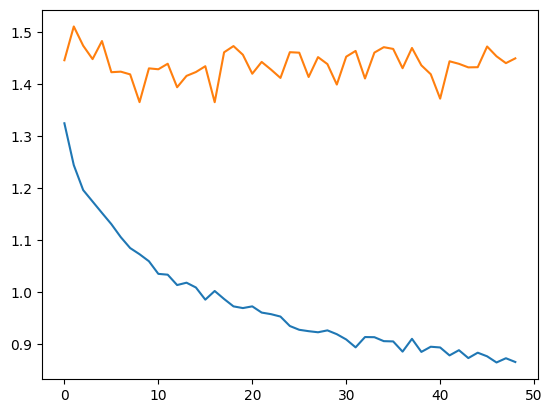

In [20]:
bciiv2a_EEGNet, bciiv2a_data = bciiv2a(EEGNet, epochs=49, Reptile=False)

In [21]:
evaluate0(bciiv2a_EEGNet, bciiv2a_data)

0-shot accuracy on subject 2: 	mean: 47.743056%	std: 12.513255%
0-shot accuracy on subject 3: 	mean: 75.173611%	std: 12.367888%
0-shot accuracy on subject 4: 	mean: 60.243056%	std: 12.071904%
0-shot accuracy on subject 5: 	mean: 48.958333%	std: 9.140588%
0-shot accuracy on subject 6: 	mean: 57.638889%	std: 11.795339%
0-shot accuracy on subject 7: 	mean: 67.187500%	std: 10.031958%
0-shot accuracy on subject 8: 	mean: 74.652778%	std: 10.819748%
0-shot accuracy on subject 9: 	mean: 77.430556%	std: 9.912571%


In [22]:
results_bciiv2a_EEGNet = evaluate(bciiv2a_EEGNet, bciiv2a_data)

0-shot accuracy: 	mean: 63.541667%	std: 11.646187%


100%|██████████| 73/73 [07:38<00:00,  6.28s/it]


1-shot accuracy: 	mean: 60.714286%	std: 13.555559%	after 125 updates


100%|██████████| 73/73 [10:14<00:00,  8.42s/it]


2-shot accuracy: 	mean: 64.322917%	std: 10.746724%	after 61 updates


100%|██████████| 73/73 [12:22<00:00, 10.17s/it]


3-shot accuracy: 	mean: 66.875000%	std: 9.291293%	after 101 updates


100%|██████████| 73/73 [09:51<00:00,  8.11s/it]


4-shot accuracy: 	mean: 68.750000%	std: 11.410887%	after 77 updates


100%|██████████| 73/73 [11:08<00:00,  9.16s/it]


5-shot accuracy: 	mean: 69.531250%	std: 12.278308%	after 65 updates


100%|██████████| 73/73 [11:31<00:00,  9.47s/it]


6-shot accuracy: 	mean: 69.196429%	std: 8.984202%	after 123 updates


100%|██████████| 73/73 [12:31<00:00, 10.30s/it]


7-shot accuracy: 	mean: 70.192308%	std: 12.294915%	after 65 updates


100%|██████████| 73/73 [13:51<00:00, 11.40s/it]


8-shot accuracy: 	mean: 71.354167%	std: 9.702050%	after 113 updates


100%|██████████| 73/73 [17:40<00:00, 14.53s/it]


9-shot accuracy: 	mean: 73.863636%	std: 9.906589%	after 73 updates


100%|██████████| 73/73 [17:22<00:00, 14.28s/it]

10-shot accuracy: 	mean: 72.500000%	std: 10.532687%	after 77 updates


In [23]:
bciiv2a_EEGNet_Reptile, bciiv2a_data = bciiv2a(EEGNet, iterations=20000, Reptile=True)

episode: 0 	finetune acc:21.250000 		test acc:41.666667
episode: 50 	finetune acc:41.250000 		test acc:56.250000
episode: 100 	finetune acc:46.250000 		test acc:54.166667
episode: 150 	finetune acc:50.000000 		test acc:45.833333
episode: 200 	finetune acc:51.250000 		test acc:70.833333
episode: 250 	finetune acc:42.500000 		test acc:52.083333
episode: 300 	finetune acc:53.750000 		test acc:70.833333
episode: 350 	finetune acc:42.500000 		test acc:66.666667
episode: 400 	finetune acc:48.750000 		test acc:64.583333
episode: 450 	finetune acc:60.000000 		test acc:64.583333
episode: 500 	finetune acc:56.250000 		test acc:62.500000
episode: 550 	finetune acc:60.000000 		test acc:60.416667
episode: 600 	finetune acc:48.750000 		test acc:64.583333
episode: 650 	finetune acc:55.000000 		test acc:52.083333
episode: 700 	finetune acc:35.000000 		test acc:54.166667
episode: 750 	finetune acc:60.000000 		test acc:56.250000
episode: 800 	finetune acc:55.000000 		test acc:47.916667
episode: 850 	fin

In [24]:
evaluate0(bciiv2a_EEGNet_Reptile, bciiv2a_data)

0-shot accuracy on subject 2: 	mean: 52.604167%	std: 11.060813%
0-shot accuracy on subject 3: 	mean: 84.201389%	std: 9.138939%
0-shot accuracy on subject 4: 	mean: 67.361111%	std: 11.977909%
0-shot accuracy on subject 5: 	mean: 59.548611%	std: 12.279842%
0-shot accuracy on subject 6: 	mean: 59.375000%	std: 10.468620%
0-shot accuracy on subject 7: 	mean: 80.034722%	std: 10.292958%
0-shot accuracy on subject 8: 	mean: 80.034722%	std: 9.178430%
0-shot accuracy on subject 9: 	mean: 78.993056%	std: 9.788650%


In [25]:
results_bciiv2a_EEGNet_Reptile = evaluate(bciiv2a_EEGNet_Reptile, bciiv2a_data)

0-shot accuracy: 	mean: 70.833333%	std: 13.339842%


100%|██████████| 73/73 [07:09<00:00,  5.89s/it]


1-shot accuracy: 	mean: 64.955357%	std: 12.758410%	after 7 updates


100%|██████████| 73/73 [11:03<00:00,  9.08s/it]


2-shot accuracy: 	mean: 66.145833%	std: 11.956500%	after 59 updates


100%|██████████| 73/73 [12:03<00:00,  9.91s/it]


3-shot accuracy: 	mean: 69.062500%	std: 9.777805%	after 7 updates


100%|██████████| 73/73 [10:13<00:00,  8.41s/it]


4-shot accuracy: 	mean: 70.486111%	std: 9.034453%	after 35 updates


100%|██████████| 73/73 [10:51<00:00,  8.93s/it]


5-shot accuracy: 	mean: 71.093750%	std: 11.240230%	after 133 updates


100%|██████████| 73/73 [11:26<00:00,  9.40s/it]


6-shot accuracy: 	mean: 73.214286%	std: 6.438484%	after 147 updates


100%|██████████| 73/73 [12:51<00:00, 10.57s/it]


7-shot accuracy: 	mean: 74.519231%	std: 11.618313%	after 143 updates


100%|██████████| 73/73 [14:11<00:00, 11.66s/it]


8-shot accuracy: 	mean: 73.958333%	std: 9.140588%	after 71 updates


100%|██████████| 73/73 [17:30<00:00, 14.39s/it]


9-shot accuracy: 	mean: 75.000000%	std: 13.588933%	after 47 updates


100%|██████████| 73/73 [17:39<00:00, 14.51s/it]

10-shot accuracy: 	mean: 76.250000%	std: 9.185587%	after 137 updates
